# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

## Test Images

In [2]:
test1 = cv2.imread('test_images/test1.jpg')
test2 = cv2.imread('test_images/test2.jpg')
test3 = cv2.imread('test_images/test3.jpg')
test4 = cv2.imread('test_images/test4.jpg')
test5 = cv2.imread('test_images/test5.jpg')
test6 = cv2.imread('test_images/test6.jpg')
test = [test1,test2,test3,test4,test5,test6]

## Camera Calibration

Here I will calibrate the camera using checkboards

In [ ]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [4]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [5]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

I will test the calibration on a test image

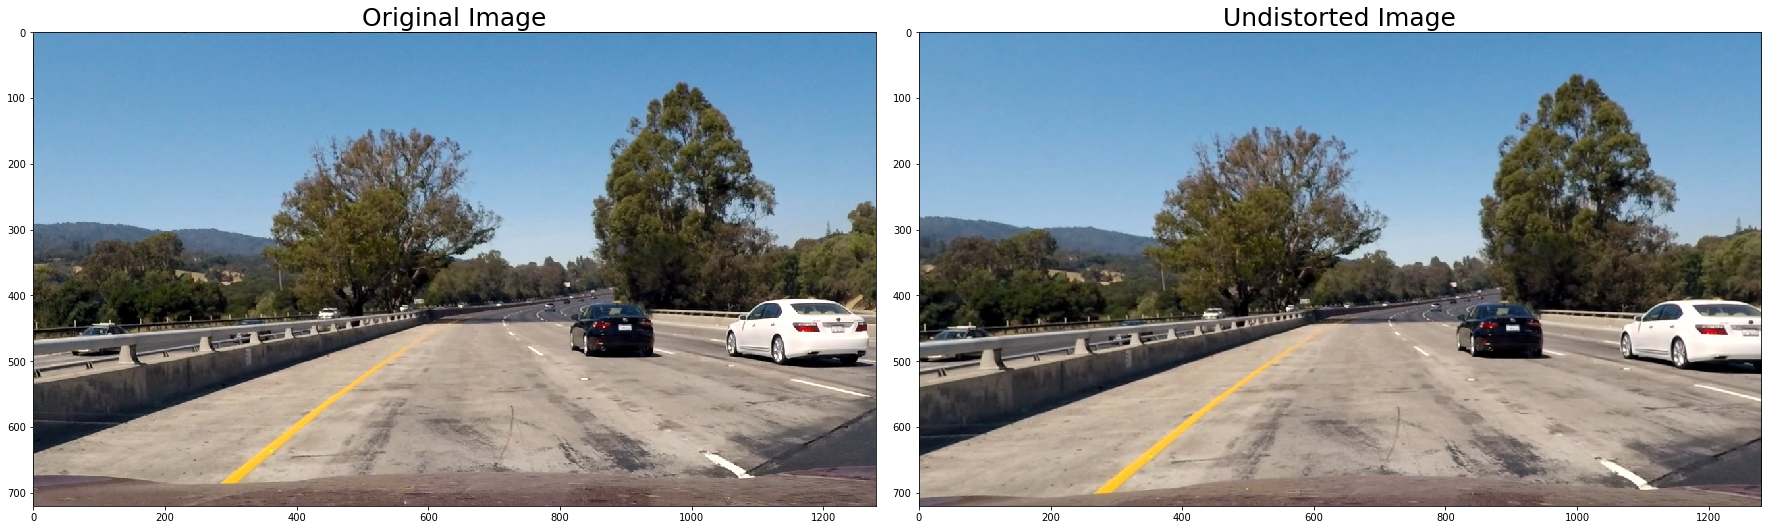

In [6]:
undistorted = undistort(test1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(test1, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Perspective Transformation

Here I will transform the road to a bird eye view so that we could measure the curvature of the road better.I will first use images with straight lines to identify the source and destiny points for the transformation.

### Straight Lane Images

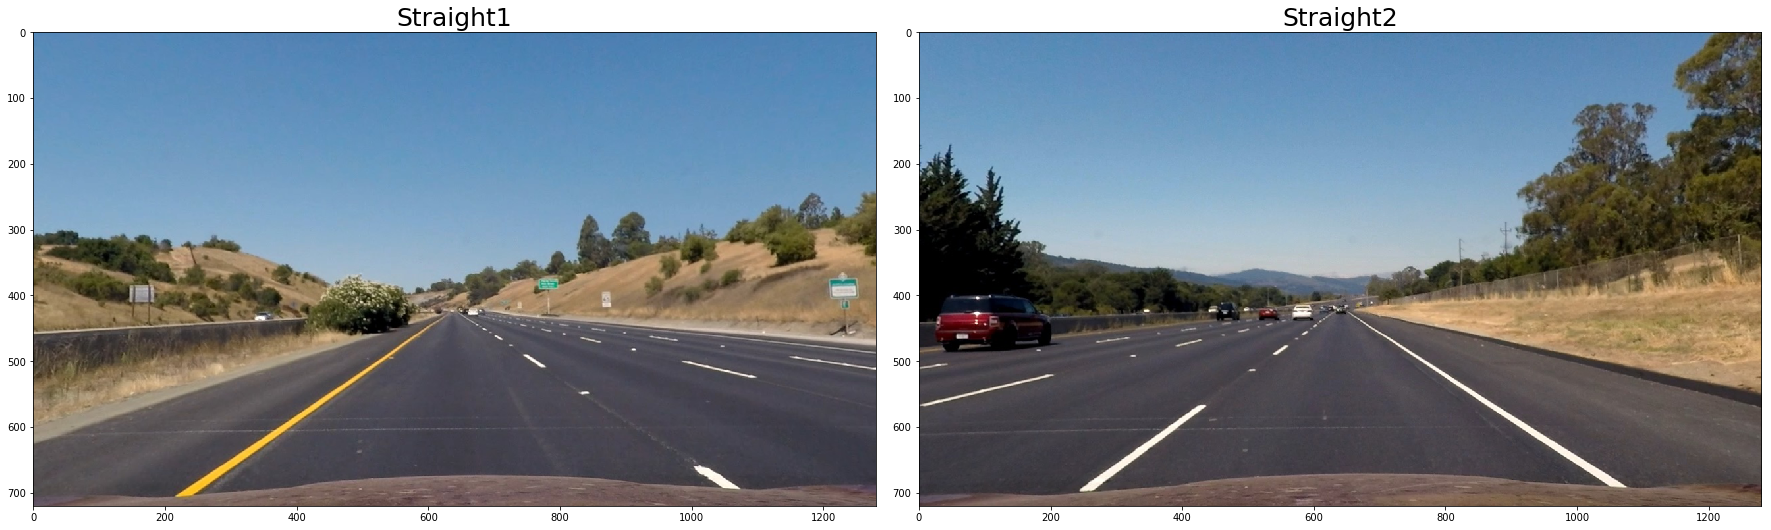

In [7]:
straight1=cv2.imread('test_images/straight_lines1.jpg')
straight2=cv2.imread('test_images/straight_lines2.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(undistort(straight1), cv2.COLOR_BGR2RGB))
ax1.set_title('Straight1', fontsize=25)
ax2.imshow(cv2.cvtColor(undistort(straight2), cv2.COLOR_BGR2RGB))
ax2.set_title('Straight2', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Warped Straight Line

In [8]:
def perspective(img):
    
    width = img.shape[1]
    height = img.shape[0]
    
    # create source
    src = np.array([[(190,720),(599, 445), (679, 445),(1124,720)]],dtype=np.float32)
    # create destiny
    dst = np.array([[(200,720),(200,0),(970,0),(970,720)]],dtype=np.float32)
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (width,height))
    
    return warped,M

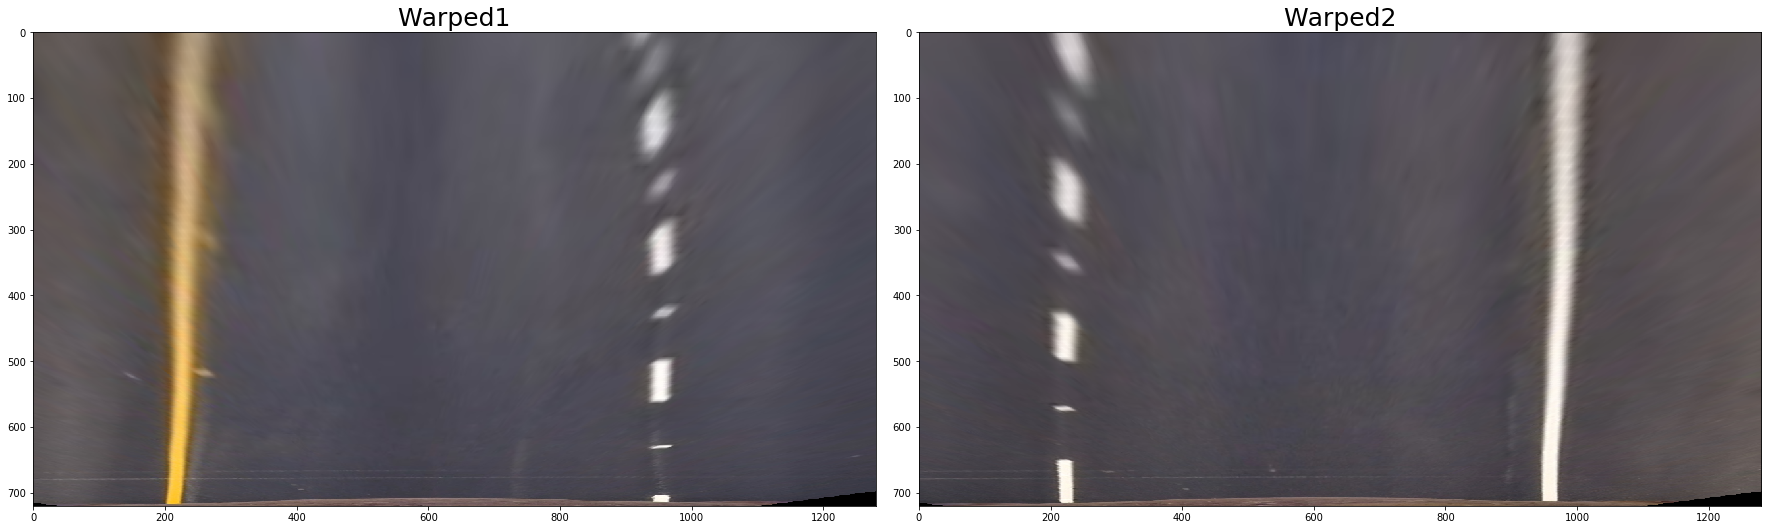

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
warped1,_=perspective(undistort(straight1))
ax1.imshow(cv2.cvtColor(warped1, cv2.COLOR_BGR2RGB))  # first undistort, then apply warped
ax1.set_title('Warped1', fontsize=25)
warped2,_=perspective(undistort(straight2))
ax2.imshow(cv2.cvtColor(warped2, cv2.COLOR_BGR2RGB))  # same
ax2.set_title('Warped2', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Warped Curved Lines

Here are the warped view of the test images after applying the mask

In [10]:
warped=[]
for img in test:
    warped_img,_=perspective(undistort(img))
    warped.append(warped_img)

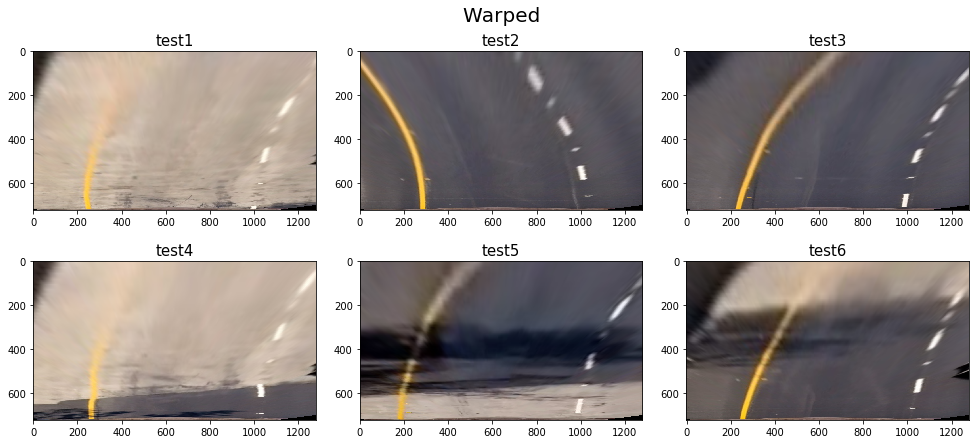

In [11]:
fig, axies = plt.subplots(2,3,figsize=(13,6))
fig.tight_layout()
fig.suptitle('Warped', fontsize=20)

for i in range(6):
    row = int(i/3)
    col = i%3
    axies[row][col].set_title('test'+str(i+1), fontdict={'fontsize':15})
    img = warped[i]
    axies[row][col].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Edge Detection

Now I will combine two methods for edge detection: thresholding with HLS, and convolution of Sobel Operator

### Thresholding Color

In [12]:
def threshold(img,smin=160,smax=255):
    # convert the image from BGR to HLS and take the saturation and lightness channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    sat = hls[:,:,2]
    hue = hls[:,:,0]
    lig = hls[:,:,1]
    # create a black and white image, white at points whose saturation is within the threshold
    binary = np.zeros_like(sat)
    #!!! since the larger the lightness, the smaller the saturation, here we compensate that by dividing the lightness from the threshold
    lower = np.minimum(smin/(0.5+lig/255),np.full(lig.shape,smax))
    higher = np.full(lig.shape,smax)
    binary[(sat>lower)&(sat<higher)]=1
    
    return binary


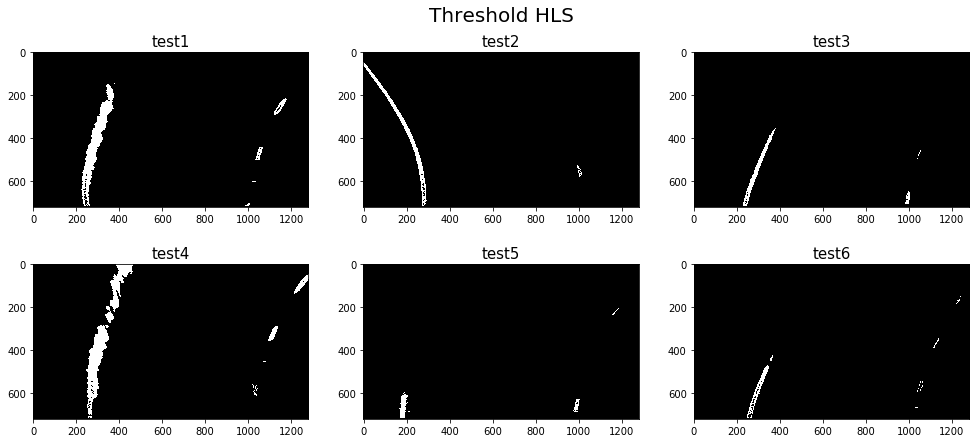

In [13]:
fig, axies = plt.subplots(2,3,figsize=(13,6))
f.tight_layout()
fig.suptitle('Threshold HLS', fontsize=20)

for i in range(6):
    row = int(i/3)
    col = i%3
    axies[row][col].set_title('test'+str(i+1), fontdict={'fontsize':15})
    img = threshold(warped[i])
    axies[row][col].imshow(img,cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Sobel Operator

In [14]:
def sobelx(img,ker=3,xmin=15,xmax=50):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Convolute the image with Sobel kernel in the horizontal direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ker) # Convolve
    abs_sobelx = np.absolute(sobelx) # Take absolute value to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx)) # Convert image to 8 bits for various image formats
    
    # Threshold the absolute value
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= xmin) & (scaled_sobelx <= xmax)] = 1

    return sxbinary

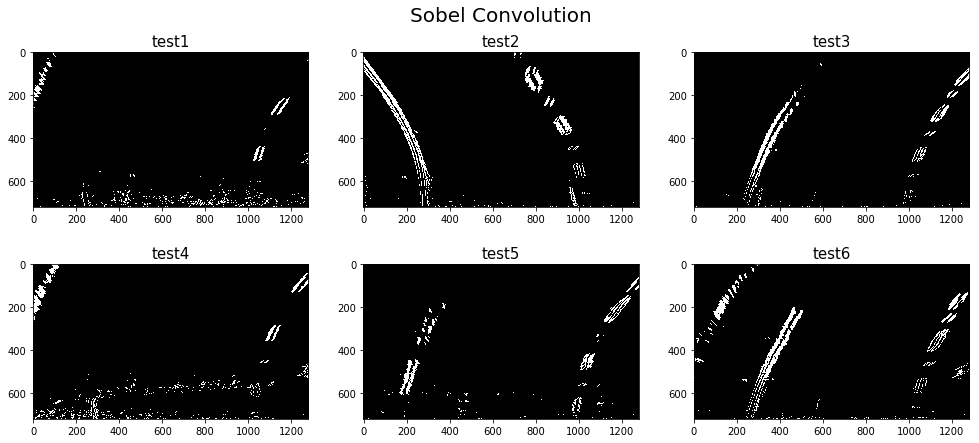

In [15]:
fig, axies = plt.subplots(2,3,figsize=(13,6))
f.tight_layout()
fig.suptitle('Sobel Convolution', fontsize=20)

for i in range(6):
    row = int(i/3)
    col = i%3
    axies[row][col].set_title('test'+str(i+1), fontdict={'fontsize':15})
    img = sobelx(warped[i])
    axies[row][col].imshow(img,cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Combine Them!

In [16]:
def edge(img):
    
    # apply
    sbinary = threshold(img)
    sxbinary = sobelx(img)
    #combine
    binary = np.zeros_like(sbinary)
    binary[(sbinary == 1) | (sxbinary == 1)] = 1
    
    return binary
    

In [17]:
edged=[]
for img in warped:
    edged.append(edge(img))

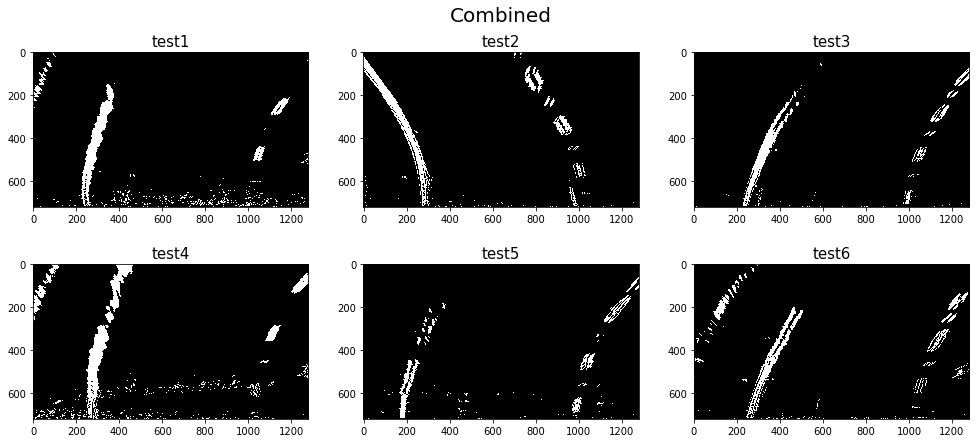

In [18]:
fig, axies = plt.subplots(2,3,figsize=(13,6))
f.tight_layout()
fig.suptitle('Combined', fontsize=20)

for i in range(6):
    row = int(i/3)
    col = i%3
    axies[row][col].set_title('test'+str(i+1), fontdict={'fontsize':15})
    img = edged[i]
    axies[row][col].imshow(img,cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Fit Curve

Now we fit the left and right lane with two second degree curves.

### Histogram

In [19]:
def histogram(img):
    return np.sum(img[img.shape[0]//2:,:], axis=0)

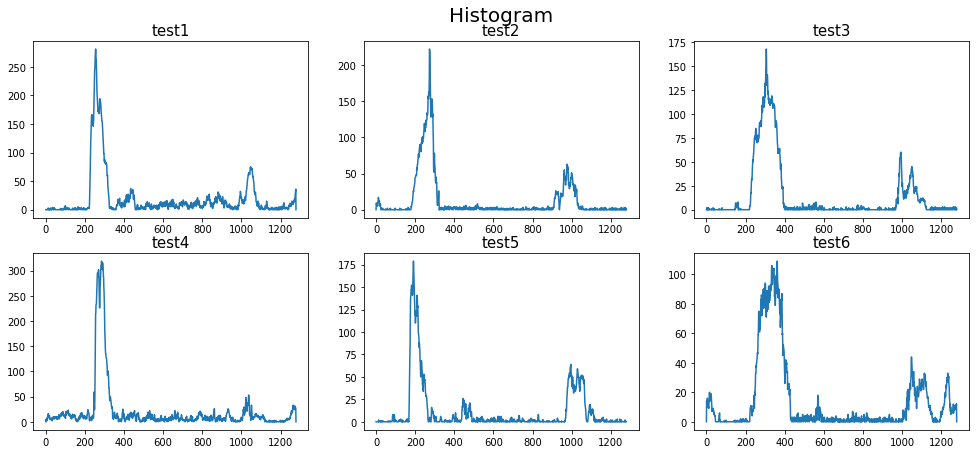

In [20]:
fig, axies = plt.subplots(2,3,figsize=(13,6))
f.tight_layout()
fig.suptitle('Histogram', fontsize=20)

for i in range(6):
    row = int(i/3)
    col = i%3
    axies[row][col].set_title('test'+str(i+1), fontdict={'fontsize':15})
    hist = histogram(edged[i])
    axies[row][col].plot(hist)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Base Point

In [21]:
def base(img):
    hist = histogram(img)
    left_oct = np.int(hist.shape[0]/8)
    midpoint = np.int(hist.shape[0]/2)
    right_oct = np.int(7*hist.shape[0]/8)
    left_base = np.argmax(hist[left_oct:midpoint])+left_oct
    right_base = np.argmax(hist[midpoint:right_oct]) + midpoint
    return left_base,right_base

### Sliding Window

In [26]:
ym_per_pix = 30/720
xm_per_pix = 3.7/700

In [37]:
def fit_first(img,base,winwidth=100,minpix=50,step=18):  
    
    imgheight = img.shape[0]
    winheight = int(imgheight/step)
    
    # current x is the middle of the current window in x direction
    # current y is the bottom of the current window in y direction
    current_x= base
    current_x_arr=[current_x]
    current_y = imgheight
    current_y_arr=[current_y]
    
    white_pos_x_arr=[]
    white_pos_y_arr=[]
    
    # shift window upward for each step
    for i in range(step):
        # find current left and right window
        window = img[(current_y-winheight):current_y,int(current_x-winwidth/2):int(current_x+winwidth/2)]
        # find white pixels
        white_pos_y,white_pos_x = window.nonzero()
        # adjust to find their coordinate in the original image
        shift_x = int(current_x-winwidth/2)
        shift_y = current_y-winheight
        white_pos_x += shift_x
        white_pos_y += shift_y
        # update current_x
        if len(white_pos_x)>minpix:
            current_x = int(np.mean(white_pos_x,axis=0))
        # update current_y(shift window upwards)
        current_y -= winheight
        # append
        white_pos_x_arr.append(white_pos_x)
        white_pos_y_arr.append(white_pos_y)
        current_x_arr.append(current_x)
        current_y_arr.append(current_y)
    # fit poly  
    white_pos_x = np.concatenate(white_pos_x_arr)
    white_pos_y = np.concatenate(white_pos_y_arr)
    fit = np.polyfit(white_pos_y, white_pos_x,2)
    fit_m = np.polyfit(white_pos_y*ym_per_pix, white_pos_x*xm_per_pix,2)
    
    return fit,fit_m

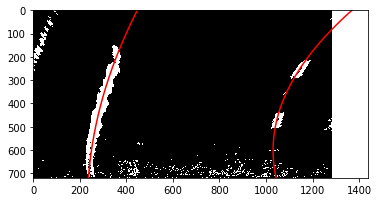

In [38]:
img = np.copy(edged[0])
left_base,right_base=base(img)
left_fit,left_fit_m=fit_first(img,left_base)
right_fit,right_fit_m=fit_first(img,right_base)
ploty = np.linspace(0,img.shape[0]-1, img.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(img,cmap='gray',vmin=0,vmax=1)
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='red')

### Finding the Rest

In [39]:
def fit_rest(img,prev_fit,swidth=100):
    # find all white in img
    white_y_arr,white_x_arr = img.nonzero()
    # bound white searching within search width of prev-fit
    ind= (white_x_arr > (prev_fit[0]*((white_y_arr)**2) + prev_fit[1]*(white_y_arr) + prev_fit[2] - swidth)) & \
        (white_x_arr < (prev_fit[0]*((white_y_arr)**2) + prev_fit[1]*(white_y_arr) + prev_fit[2] + swidth))
    fit = np.polyfit(white_y_arr[ind], white_x_arr[ind],2)
    fit_m = np.polyfit(white_y_arr[ind]*ym_per_pix, white_x_arr[ind]*xm_per_pix, 2)
    return fit,fit_m

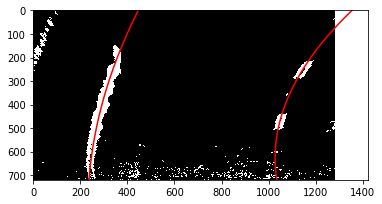

In [41]:
img = np.copy(edged[0])
left_base,right_base=base(img)
left_fit2,left_fit2_m=fit_rest(img,left_fit)
right_fit2,right_fit2_m=fit_rest(img,right_fit)
ploty = np.linspace(0,img.shape[0]-1, img.shape[0])
left_fitx = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

plt.imshow(img,cmap='gray',vmin=0,vmax=1)
plt.plot(left_fitx, ploty, color='red')
plt.plot(right_fitx, ploty, color='red')

## Curvature and Shift

In [59]:
def curvature(left_fit,right_fit,y):
    left_curvature = ((1 + (2*left_fit[0]*y*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curvature = ((1 + (2*right_fit[0]*y*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    avg = (left_curvature + right_curvature)/2
    return int(avg)

In [60]:
print('curvature:{}'.format(curvature(left_fit2_m,right_fit2_m,720)))

curvature:376


In [77]:
def shift(left_fit,right_fit,y,width):
    left_point = left_fit[0]*(y*ym_per_pix)**2 + left_fit[1]*(y*ym_per_pix) + left_fit[2]
    right_point = right_fit[0]*(y*ym_per_pix)**2 + right_fit[1]*(y*ym_per_pix) + right_fit[2]
    mid = (left_point + right_point)/2
    image_mid = width*xm_per_pix
    return mid - image_mid/2

In [78]:
print('curvature:{}'.format(shift(left_fit2_m,right_fit2_m,720,1280)))

curvature:-0.022125687326908228


## Pipeline for Image

In [53]:
def main_first(img):
    height=img.shape[0]
    warped,_=perspective(undistort(img))
    warped_edge=edge(warped)
    left_base,right_base=base(warped_edge)
    left_fit,_=fit_first(warped_edge,left_base)
    right_fit,_=fit_first(warped_edge,right_base)
    return left_fit,right_fit

In [82]:
def main_rest(img,prev_left_fit,prev_right_fit):
    height=img.shape[0]
    width=img.shape[1]
    warped,M=perspective(undistort(img))
    warped_edge=edge(warped)
    left_base,right_base=base(warped_edge)
    left_fit,left_fit_m=fit_rest(warped_edge,prev_left_fit)
    right_fit,right_fit_m=fit_rest(warped_edge,prev_right_fit)
    curv=curvature(left_fit_m,right_fit_m,height)
    shif=shift(left_fit_m,right_fit_m,height,width)
    
    return left_fit,right_fit,curv,shif,M

In [91]:
def draw(img,left_fit,right_fit,curv,shif,M):
    
    # Create an image to draw the lines on
    canvas=np.zeros_like(img)
    # get fitted points
    ploty = np.linspace(0,img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(canvas, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    warped = cv2.warpPerspective(canvas, np.linalg.inv(M), (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, warped, 0.3, 0)
    
    cv2.putText(result, 'Curvature:{}m'.format(int(curv)),(50, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, [255,255,255], 2)
    cv2.putText(result, 'Shift:{:.2f}m'.format(shif),(50,200),cv2.FONT_HERSHEY_SIMPLEX, 2, [255,255,255], 2)

    return result

In [88]:
def process_img(img):
    init_left_fit,init_right_fit=main_first(img)
    left_fit,right_fit,curv,shif,M=main_rest(img,init_left_fit,init_right_fit)
    result=draw(img,left_fit,right_fit,curv,shif,M)
    return result

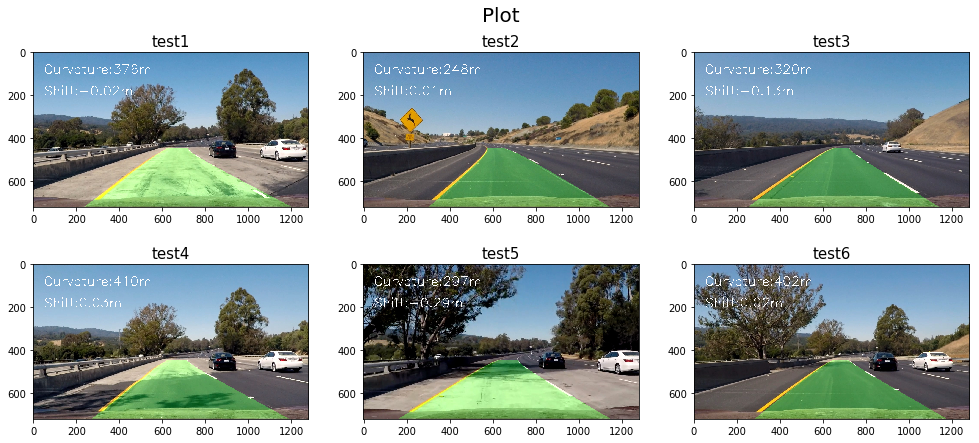

In [92]:
fig, axies = plt.subplots(2,3,figsize=(13,6))
f.tight_layout()
fig.suptitle('Plot', fontsize=20)

for i in range(6):
    row = int(i/3)
    col = i%3
    axies[row][col].set_title('test'+str(i+1), fontdict={'fontsize':15})
    img = process_img(test[i])
    axies[row][col].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Process Video

In [95]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'result.mp4'
clip = VideoFileClip("project_video.mp4")

In [99]:
initial_frame=clip.get_frame(0)
global i
i=0
global current_left_fit,current_right_fit
current_left_fit,current_right_fit=main_first(initial_frame)
global last5_left_fit,last5_right_fit
last5_left_fit=[]
last5_right_fit=[]
global drawing_left_fit,drawing_right_fit
drawing_left_fit=[]
drawing_right_fit=[]
global show_curv,show_shif
show_curv=0
show_shif=0


In [100]:
def process(img):
    global i
    global current_left_fit,current_right_fit
    global last5_left_fit,last5_right_fit
    global drawing_left_fit,drawing_right_fit
    global show_curv,show_shif
    current_left_fit,current_right_fit,curv,shif,M=main_rest(img,current_left_fit,current_right_fit)
    last5_left_fit.append(current_left_fit)
    last5_right_fit.append(current_right_fit)
    if i%5==0:
        drawing_left_fit=np.mean(last5_left_fit,axis=0)
        drawing_right_fit=np.mean(last5_right_fit,axis=0)
        last5_left_fit=[]
        last5_right_fit=[]
        show_curv=curv
        show_shif=shif
    result=draw(img,drawing_left_fit,drawing_right_fit,show_curv,show_shif,M)
    i+=1
    return result

In [101]:
result=clip.fl_image(process)
%time result.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [01:57<00:00, 10.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 2min 23s, sys: 23.6 s, total: 2min 46s
Wall time: 1min 57s
